### 머신러닝의 성능 평가 지표

    머신러닝의 예측 성능 평가 지표는 estimator에 달려있음
     1. 회귀 : 실제 값과 예측값의 오차 평균값에 기반. ex) MAE, MSE, RMSLE 등
     2. 분류 : 일반적으로는 실제 데이터와 예측 데이터의 오류를 기반으로 하지만 상황에 따라 조금 더 복잡해짐 ex) 정확도, F1 score 등

### 1. 정확도(Accuracy)

    실제 데이터와 예측데이터가 얼마나 같은지를 판단하는 지표
    
    정확도 = 예측결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
    
    가장 직관적이지만 경우에 따라서 ML 모델의 성능을 왜곡할 수 있음

#### 1.1 타이타닉 데이터 셋

In [1]:
# 아무런 학습을 하지 않고 성별에 따라서만 생존자를 예측하는 MyDummyClassifier 클래스 생성

from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1
        return pred

In [2]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 불필요한 칼럼 제거 함수
def drop_features(df):
    df.drop(['Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행 함수
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 모든 과정을 총괄하는 함수 생성
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
# 정의한 클래스로 타이타닉 생존자 예측 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

## 정의한 Dummy Classifier를 이용 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

my_prediction = myclf.predict(X_test)
print(f'Dummy Classifier의 정확도는 : {accuracy_score(my_prediction, y_test):.4f}')

Dummy Classifier의 정확도는 : 0.7877


#### 1.2 MNIST 데이터 셋

    단지 성별만 가지고 예측한 모델의 정확도가 80%에 육박
    특히 레이블 값이 불균형한 데이터에서는 이러한 문제가 두드러짐

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True, 이를 astype(int)로 1로 변환 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [5]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)

print(f'모든 예측을 0으로 하여도 정확도는 {accuracy_score(fakepred,y_test):.4f}')

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 0.9000


### 2. 오차 행렬
    이진분류 시 학습된 분류모델에 어떠한 유형의 예측오류를 발생하는 지 나타내는 지표
    TN / TP / FN / FP 로 이뤄져있으며 앞의 TF는 실제값과 예측값의 정답 여부를, 뒤의 PN은 예측결과값을 의미

    오차 행렬은 그대로 사용한다기 보단 정확도, 재현율, 정밀도를 계산하기 위한 도구
     ** 정확도 = (TN + TP) / (TN + TP + FN + FP) 

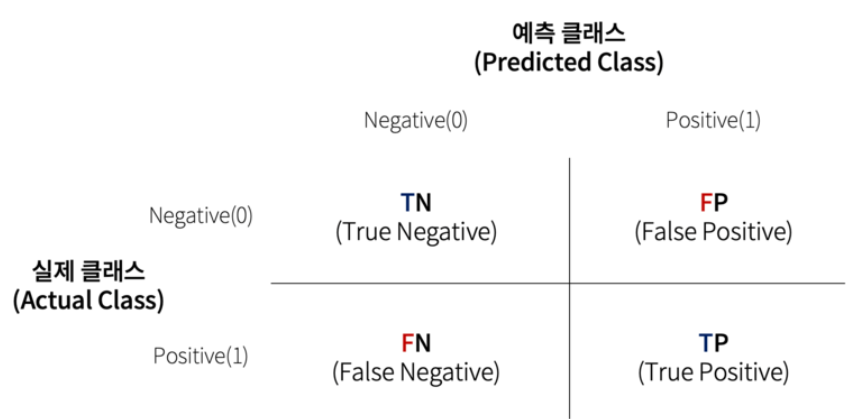

In [11]:
from IPython.display import Image

# 오차행렬
Image('image/오차행렬.png')

In [12]:
# confusion_matrix() : 사이킷런이 제공하는 오차행렬을 구하기 위한 API

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)